# Importing Libraries and Dependencies

In [96]:
import os
import torch
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from tqdm import tqdm  # Import tqdm for progress bars
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mounting Google Drive in Colab

In [97]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Custom Loss Function: Partial Cross-Entropy Loss

In [98]:
# Define the PartialCrossEntropyLoss class
class PartialCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(PartialCrossEntropyLoss, self).__init__()
        self.ce_loss = torch.nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets, mask):
        loss = self.ce_loss(inputs, targets)
        masked_loss = loss * mask.unsqueeze(2)  # Add class dimension to mask
        partial_loss = torch.sum(masked_loss) / torch.sum(mask)
        return partial_loss

# Custom Dataset Class for Remote Sensing Semantic and Instance Segmentation

In [99]:
class RemoteSensingDataset(Dataset):
    def __init__(self, semantic_mask_dir, instance_mask_dir, transform=None, target_size=(128, 128)):
        self.semantic_mask_dir = semantic_mask_dir
        self.instance_mask_dir = instance_mask_dir
        self.transform = transform
        self.semantic_mask_list = os.listdir(semantic_mask_dir)
        self.instance_mask_list = os.listdir(instance_mask_dir)
        self.target_size = target_size

    def __len__(self):
        return min(len(self.semantic_mask_list), len(self.instance_mask_list))

    def __getitem__(self, idx):
        semantic_mask_name = self.semantic_mask_list[idx]
        instance_mask_name = self.instance_mask_list[idx]

        semantic_mask_path = os.path.join(self.semantic_mask_dir, semantic_mask_name)
        instance_mask_path = os.path.join(self.instance_mask_dir, instance_mask_name)

        semantic_mask = Image.open(semantic_mask_path).convert('RGB')
        instance_mask = Image.open(instance_mask_path).convert('RGB')

        # Resize images and masks
        semantic_mask = semantic_mask.resize(self.target_size, Image.NEAREST)
        instance_mask = instance_mask.resize(self.target_size, Image.NEAREST)

        # Convert masks to numpy arrays
        semantic_mask = np.array(semantic_mask)
        instance_mask = np.array(instance_mask)

        # Convert instance mask to 3D tensor
        instance_mask = instance_mask[:, :, 0]  # Select one channel
        instance_mask = self.convert_instance_mask(instance_mask)
        instance_mask = np.expand_dims(instance_mask, axis=0)  # Add channel dimension

        points = self.simulate_point_labels(semantic_mask)

        if self.transform:
            semantic_mask = self.transform(semantic_mask)
            instance_mask = torch.tensor(instance_mask, dtype=torch.long)  # Convert to tensor
            points = self.transform(points)

        return semantic_mask, instance_mask, points

    def convert_instance_mask(self, mask):
        unique_labels = np.unique(mask)
        new_mask = np.zeros_like(mask)
        for i, label in enumerate(unique_labels):
            if label == 0:  # Skip background
                continue
            new_mask[mask == label] = i
        return new_mask

    def simulate_point_labels(self, mask):
        points = np.zeros_like(mask)
        unique_labels = np.unique(mask)
        for label in unique_labels:
            if label == 0:  # Skip background
                continue
            label_indices = np.where(mask == label)
            num_points = min(10, len(label_indices[0]))  # Simulate up to 10 points per class
            sampled_indices = np.random.choice(range(len(label_indices[0])), num_points, replace=False)
            for idx in sampled_indices:
                points[label_indices[0][idx], label_indices[1][idx]] = label
        return points

# Defining Transformations for Data Augmentation

In [100]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Loading Remote Sensing Segmented Data

In [101]:
semantic_mask_dir = '/content/drive/MyDrive/RemoteSenseImageSegmentationData/Semantic_mask'
instance_mask_dir = '/content/drive/MyDrive/RemoteSenseImageSegmentationData/Instance_mask'

dataset = RemoteSensingDataset(semantic_mask_dir, instance_mask_dir, transform=transform, target_size=(128, 128))

# Splitting Dataset into Training and Validation Sets and Creating Data Loaders

In [102]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Loading Pretrained DeepLabV3 Model and Modifying Final Classifier Layer

In [103]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Defining Loss Function and Optimizer

In [104]:
criterion = PartialCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and Validation Loop with Metrics Calculation

In [105]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_train_true_labels = []
    all_train_pred_labels = []
    tqdm_dataloader = tqdm(train_dataloader)  # Wrap dataloader with tqdm
    for semantic_masks, instance_masks, points in tqdm_dataloader:
        optimizer.zero_grad()

        outputs = model(semantic_masks)['out']

        # Apply softmax activation
        outputs = torch.nn.functional.softmax(outputs, dim=1)

        # Reshape instance_masks and points to remove the extra dimension
        instance_masks = instance_masks.squeeze(1)
        points = points.squeeze(1)

        loss = criterion(outputs, instance_masks, points)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        tqdm_dataloader.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(tqdm_dataloader):.4f}')  # Update tqdm description

        _, predicted = torch.max(outputs.data, 1)
        total += instance_masks.nelement()
        correct += (predicted == instance_masks).sum().item()

        # Collect true and predicted labels for the classification report
        all_train_true_labels.extend(instance_masks.cpu().numpy().flatten())
        all_train_pred_labels.extend(predicted.cpu().numpy().flatten())

    train_accuracy = correct / total

    # Generate training classification report
    train_precision = precision_score(all_train_true_labels, all_train_pred_labels, average='weighted')
    train_recall = recall_score(all_train_true_labels, all_train_pred_labels, average='weighted')
    train_f1 = f1_score(all_train_true_labels, all_train_pred_labels, average='weighted')

    #---------------------------------------------------------------#


    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    all_val_true_labels = []
    all_val_pred_labels = []
    with torch.no_grad():
        for semantic_masks, instance_masks, points in tqdm(val_dataloader):
            outputs = model(semantic_masks)['out']
            outputs = torch.nn.functional.softmax(outputs, dim=1)
            instance_masks = instance_masks.squeeze(1)
            points = points.squeeze(1)
            loss = criterion(outputs, instance_masks, points)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += instance_masks.nelement()
            val_correct += (predicted == instance_masks).sum().item()

            # Collect true and predicted labels for the classification report
            all_val_true_labels.extend(instance_masks.cpu().numpy().flatten())
            all_val_pred_labels.extend(predicted.cpu().numpy().flatten())

    val_accuracy = val_correct / val_total


    # Generate validation classification report
    val_precision = precision_score(all_val_true_labels, all_val_pred_labels, average='weighted')
    val_recall = recall_score(all_val_true_labels, all_val_pred_labels, average='weighted')
    val_f1 = f1_score(all_val_true_labels, all_val_pred_labels, average='weighted')


Epoch [1/2], Loss: 10.2651: 100%|██████████| 282/282 [29:38<00:00,  6.31s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 71/71 [02:53<00:00,  2.44s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

# Printing Training Metrics

In [106]:
print(f"Epoch [{epoch+1}/{num_epochs}]")
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Training Loss: {running_loss/len(train_dataloader):.4f}")

print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")


Epoch [2/2]
Training Accuracy: 0.92
Training Loss: 9.0588
Training Precision: 0.8809
Training Recall: 0.9195
Training F1 Score: 0.8998


# Printing Validation Metrics

In [107]:
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_running_loss/len(val_dataloader):.4f}")

print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Validation Accuracy: 0.94
Validation Loss: 8.7794
Validation Precision: 0.8893
Validation Recall: 0.9430
Validation F1 Score: 0.9153


# Plotting Training and Validation Metrics

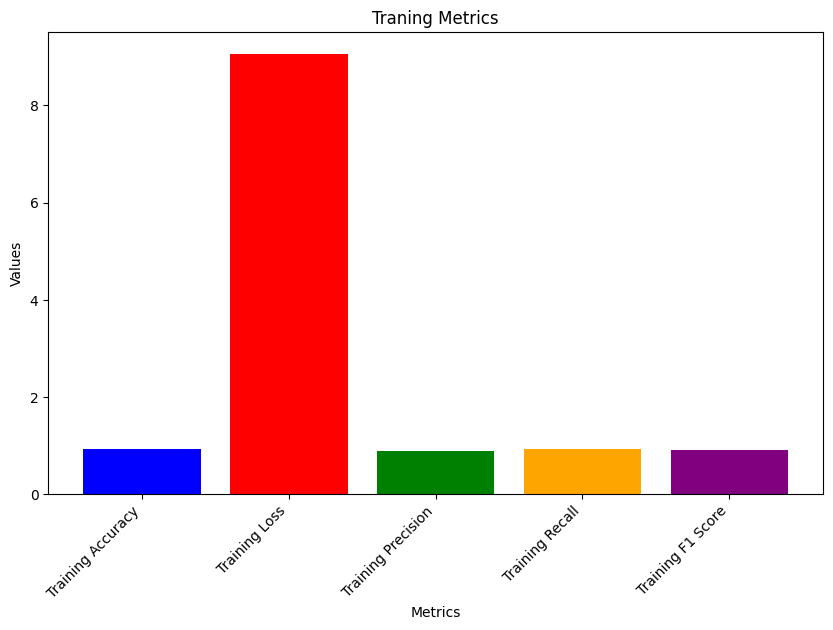

In [108]:
# Metrics and their corresponding values
metrics = ['Training Accuracy', 'Training Loss', 'Training Precision', 'Training Recall', 'Training F1 Score']
values = [train_accuracy, running_loss/len(train_dataloader), train_precision, train_recall, train_f1]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'red', 'green', 'orange', 'purple'])
plt.title('Traning Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')
plt.show()

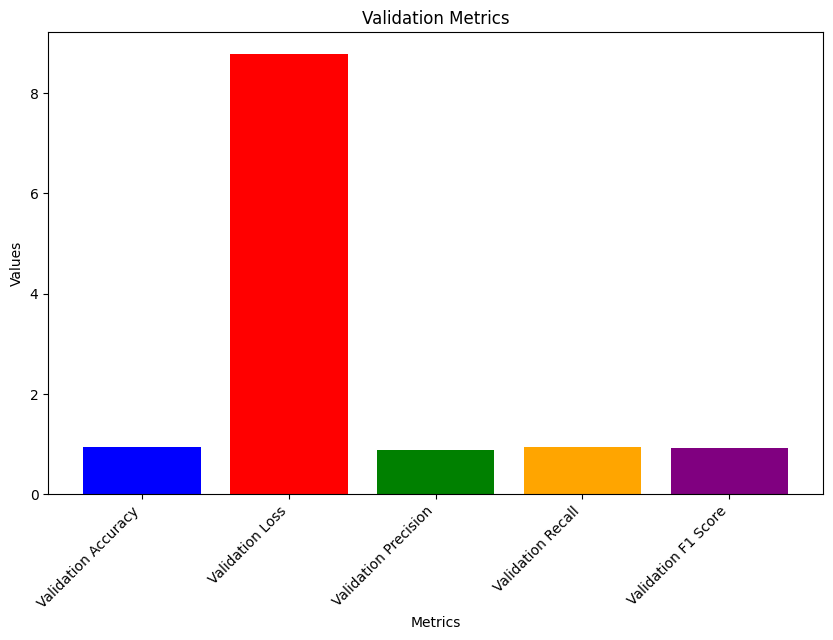

In [109]:
# Metrics and their corresponding values
metrics = ['Validation Accuracy', 'Validation Loss', 'Validation Precision', 'Validation Recall', 'Validation F1 Score']
values = [val_accuracy, val_running_loss/len(val_dataloader), val_precision, val_recall, val_f1]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'red', 'green', 'orange', 'purple'])
plt.title('Validation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')
plt.show()